# Flowers


## Download the data

In [0]:
!mkdir data
!curl http://download.tensorflow.org/example_images/flower_photos.tgz | tar xz -C data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  218M  100  218M    0     0  72.7M      0  0:00:03  0:00:03 --:--:-- 57.9M


In [0]:
!ls ./data/flower_photos/

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


Flower dataset from [Tensorflow tutorials](https://www.tensorflow.org/tutorials/image_retraining). Dataset contains about 3500 images in set of subfolders. The images are not split into training and validation dataset.

## Load libraries

In [0]:
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np
from matplotlib import patches, patheffects

In [0]:
from keras import backend as K
from keras.models import Model 
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.optimizers import Adam, SGD

In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax
  
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
  
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
           verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

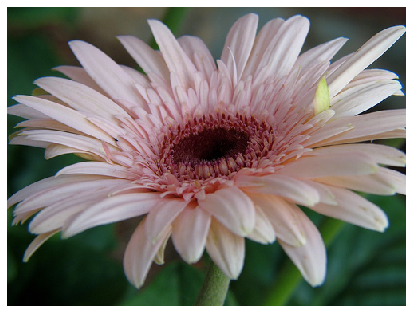

In [0]:
show_img(load_img('./data/flower_photos/daisy/1031799732_e7f4008c03.jpg'))

In [0]:
num_classes = 5
flowers = ['daisy','dandelion','roses','sunflowers','tulips']
SZ = 224
BS = 16

## Transfer learning

Try to train your flowers classifier on top of of VGG 16.

Hints: 
We have 5 different classes, so instead of binary_crossentropy and sigmoid, we are going to use categorical_crossentropy ad softmax.
The dataset is small, so data augumentation may help.  
To split the dataset into training an validation sets, use the validation_split keyword in ImageDataGenerator

In [0]:
base_model = VGG16(weights='imagenet', include_top=False)



In [0]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x) 
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


Make sure to train only the newly added layers and compile the model:

In [0]:
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=Adam(lr=1e-3),    
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

Create data generators.  

Hint:  
Use validation_split keyword in ImageDataGenerator and subset keyword in datagen.flow_from_directory().

In [0]:
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=35,  
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    horizontal_flip=True, 
    shear_range=0.1,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
  './data/flower_photos/',
  target_size=(SZ, SZ),
  batch_size=BS,
  subset='training'
    
)

validation_generator = train_datagen.flow_from_directory(
  './data/flower_photos/',
  target_size=(SZ, SZ),
  batch_size=BS,
  shuffle=False,
  subset='validation'
)

Found 3306 images belonging to 5 classes.
Found 364 images belonging to 5 classes.


Train your classifier and save its output to a variable.  Tou may need more epochs than 3.

In [0]:
%%time
history = model.fit_generator(
    train_generator, 
    train_generator.n // BS, 
    epochs=9, 
    workers=4,
    validation_data=validation_generator, 
    validation_steps=validation_generator.n // BS
)

Epoch 1/9
206/206 [==============================] - 52s 254ms/step - loss: 1.5097 - acc: 0.5605 - val_loss: 0.7389 - val_acc: 0.7301
Epoch 2/9
206/206 [==============================] - 52s 254ms/step - loss: 0.7563 - acc: 0.7258 - val_loss: 0.5612 - val_acc: 0.7898
Epoch 3/9
 97/206 [=============>................] - ETA: 24s - loss: 0.6722 - acc: 0.7469

206/206 [==============================] - 52s 254ms/step - loss: 0.6409 - acc: 0.7634 - val_loss: 0.5323 - val_acc: 0.8068
Epoch 4/9
206/206 [==============================] - 52s 252ms/step - loss: 0.5554 - acc: 0.8014 - val_loss: 0.5399 - val_acc: 0.8267
Epoch 5/9
135/206 [==================>...........] - ETA: 15s - loss: 0.4811 - acc: 0.8169

206/206 [==============================] - 52s 253ms/step - loss: 0.4942 - acc: 0.8205 - val_loss: 0.4649 - val_acc: 0.8239
Epoch 6/9
206/206 [==============================] - 52s 253ms/step - loss: 0.4906 - acc: 0.8259 - val_loss: 0.5406 - val_acc: 0.8352
Epoch 7/9
141/206 [===================>..........] - ETA: 14s - loss: 0.4270 - acc: 0.8415

206/206 [==============================] - 52s 252ms/step - loss: 0.4411 - acc: 0.8360 - val_loss: 0.4975 - val_acc: 0.8040
Epoch 8/9
206/206 [==============================] - 52s 254ms/step - loss: 0.4376 - acc: 0.8351 - val_loss: 0.4951 - val_acc: 0.8494
Epoch 9/9
145/206 [====================>.........] - ETA: 13s - loss: 0.4030 - acc: 0.8569

206/206 [==============================] - 53s 256ms/step - loss: 0.4024 - acc: 0.8538 - val_loss: 0.4487 - val_acc: 0.8580
CPU times: user 14min 11s, sys: 39.1 s, total: 14min 50s
Wall time: 7min 50s


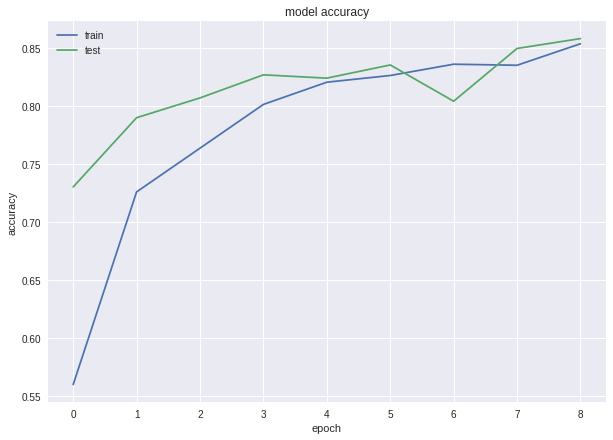

In [0]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc']) 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

## Fine tuning

In [0]:
for layer in model.layers[:25] :
    layer.trainable = False
for layer in model.layers[25:] :
    layer.trainable = True
model.compile(optimizer=SGD(lr=1e-5, momentum=0.5),    
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

fine-tune your model

In [0]:
%%time
model.fit_generator(
    train_generator, 
    train_generator.n // BS, 
    epochs=3, 
    workers=8,
    validation_data=validation_generator, 
    validation_steps=validation_generator.n // BS
)

Epoch 1/3
206/206 [==============================] - 53s 258ms/step - loss: 0.3887 - acc: 0.8540 - val_loss: 0.4484 - val_acc: 0.8466
Epoch 2/3
206/206 [==============================] - 53s 257ms/step - loss: 0.3886 - acc: 0.8554 - val_loss: 0.4781 - val_acc: 0.8523
Epoch 3/3
 96/206 [============>.................] - ETA: 25s - loss: 0.3819 - acc: 0.8633

206/206 [==============================] - 53s 256ms/step - loss: 0.3722 - acc: 0.8660 - val_loss: 0.5069 - val_acc: 0.8580
CPU times: user 4min 40s, sys: 21.2 s, total: 5min 1s
Wall time: 2min 38s


## Check predictions for the validation set

In [0]:
y_true = validation_generator.classes

In [0]:
preds = model.predict_generator(validation_generator)

In [0]:
y_pred = np.argmax(preds, axis=1) # we are looking for a class with maximum score

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Plot the confusion matrix and check which classes are missclassified most often

In [0]:
cnf_matrix = confusion_matrix(y_true, y_pred)

[[51  7  1  3  1]
 [ 0 78  1  8  2]
 [ 0  0 54  0 10]
 [ 1  1  3 62  2]
 [ 0  0  6  5 68]]


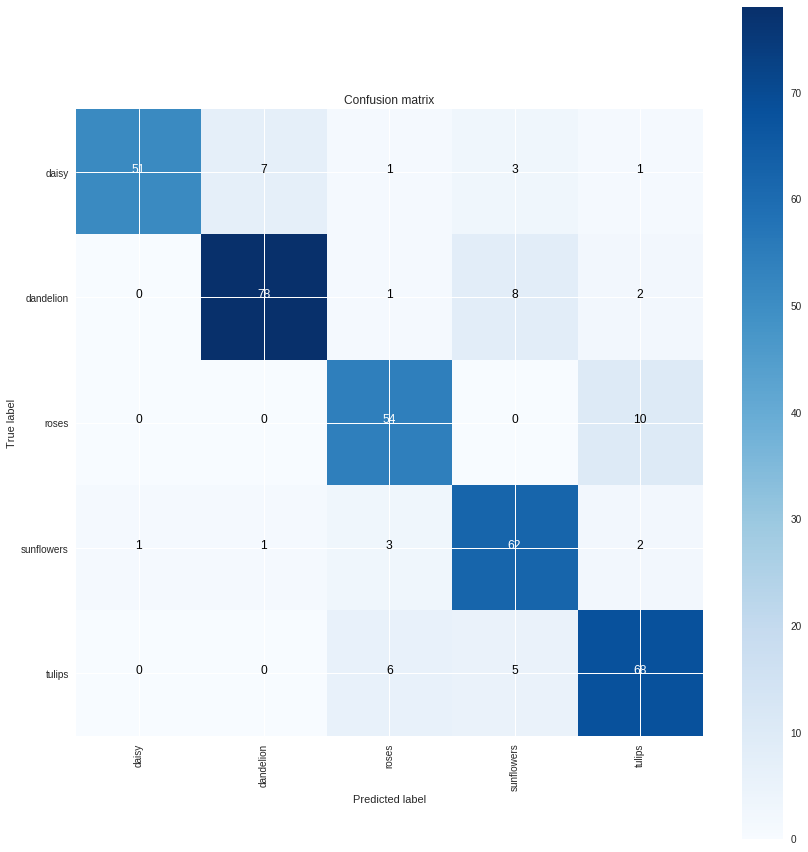

In [0]:
plot_confusion_matrix(cnf_matrix, flowers)

Plot some corectly and incorrectly classified images.

In [0]:
filenames = validation_generator.filenames

In [0]:
correct = np.where(y_pred == y_true)[0]
idx = np.random.choice(correct, 16, replace=False)

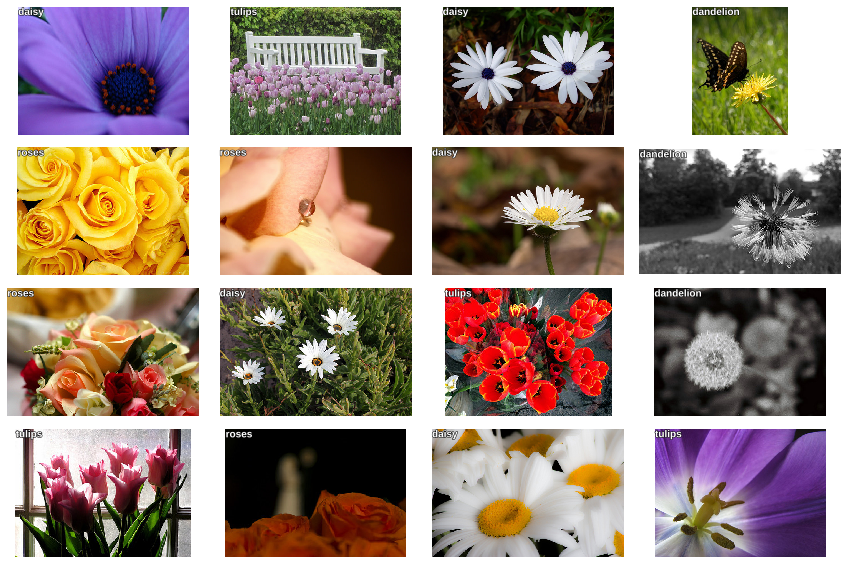

In [0]:
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima = load_img('./data/flower_photos/'+filenames[idx[i]]) 
    show_img(ima, ax=ax)
    draw_text(ax, (0,0), flowers[y_pred[idx[i]]], sz=10)
plt.tight_layout()

In [0]:
incorrect = np.where(y_pred != y_true)[0]
idx = np.random.choice(incorrect, 16, replace=False)

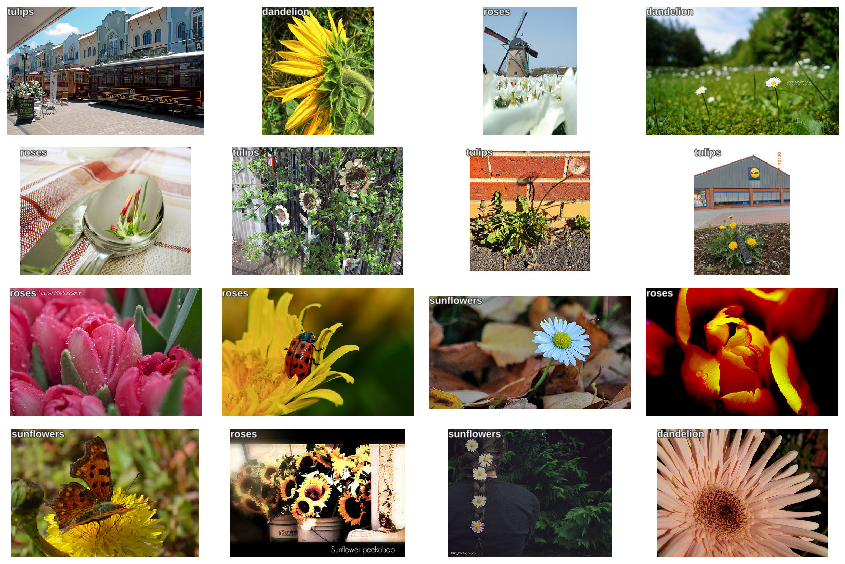

In [0]:
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima = load_img('./data/flower_photos/'+filenames[idx[i]]) 
    show_img(ima, ax=ax)
    draw_text(ax, (0,0), flowers[y_pred[idx[i]]], sz=10)
plt.tight_layout()